# **Setup**

<font color='black'>In this notebook, you will be using the NLTK's [`vader`](https://www.nltk.org/_modules/nltk/sentiment/vader.html) library, which contains the [`SentimentIntensityAnalyzer()`](https://www.nltk.org/api/nltk.sentiment.vader.html#nltk.sentiment.vader.SentimentIntensityAnalyzer) method used to assign a sentiment score to a given text. 

In [1]:
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity = "all"    # allows multiple outputs from a cell
import numpy as np, pandas as pd, nltk, seaborn as sns, matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import sentence_polarity
from sklearn.metrics import confusion_matrix, classification_report
pd.set_option('max_colwidth', 0, 'max_columns', 20)
_ = nltk.download(['vader_lexicon', 'sentence_polarity'], quiet=True)

sia = SentimentIntensityAnalyzer()

<hr style="border-top: 2px solid #606366; background: transparent;">

# **Review**

<font color='black'>The Valence Aware Dictionary for sEntiment Reasoning ([VADER](https://ojs.aaai.org/index.php/ICWSM/article/view/14550)) was developed in 2014 by C.J. Hutto and Eric Gilbert from Georgia Institute of Technology. It is a fast, simple, verifiable, and reasonably effective tool for identifying the degree of sentiment in short messages.

<font color='black'>Many sentiment analysis tools use lexicons (i.e., vocabulary) of key words with known sentiments. These can be assigned polarities (i.e., a binary sentiment, negative or positive) or a valence (i.e., a continuous polarity in some interval, say $[-1,1]$). Because sentiment is assigned by experts or the crowdsourcing community (such as Amazon Mechanical Turks), this process is expensive and laborious. Hence, many of these tools extend their lexicon to include previously labeled words. VADER also extends the well known Linguistic Inquiry and Word Count ([LIWC](http://downloads.liwc.net.s3.amazonaws.com/LIWC2015_OperatorManual.pdf)), which identified 4500 words in at least one of 76 categories, including 406 words with positive emotions (love, nice, good great) and 499 words with negative emotions (hurt, ugly, sad, bad, worse).

<font color='black'>VADER's unique contribution lies in identifying and implementing several human-curated rules extending the popular lexicons, including LIWC, Affective Norms for English Words ([ANEW](https://pdodds.w3.uvm.edu/teaching/courses/2009-08UVM-300/docs/others/everything/bradley1999a.pdf), 1034 valence-rated words on the scale 1-9), and general inquirer ([GI](https://psycnet.apa.org/record/1967-04539-000), 11K words, 1915 positive, 2291 negative). These lexicons were enlarged with Western-style emoticons (such as :-) ), acronyms and initialisms (LOL, WTF), and commonly used slang (such as nah, meh, yay). The authors then used AMC raters to reduce a lexicon with 9000 words to the validated lexicon with 7500 words. The rules accounted for intensity of emotions rising from:

1. Punctuation. For example, the exclamation signs are thought to increase the intensity
1. Capitalization, which is expected to raise the intensity
1. Degree modifies. These include words like "very," "marginally," "extremely"
1. Constructive junction of words like "but" and "however", which may result in a sentiment dominance of the following phrase
1. Negation, which are likely to flip the sentiment polarity


## Exploring VADER's Lexicon

<font color='black'>As noted below, VADER's lexicon contains ~7500 words, including emoticons. Each word is a key in a dictionary with an assigned valence score ranging from -4 to 4. 

In [2]:
print(f'{type(sia.lexicon)}, {len(sia.lexicon)} words', str(sia.lexicon)[:64], '...')

<class 'dict'>, 7502 words {'$:': -1.5, '%)': -0.4, '%-)': -1.5, '&-:': -0.4, '&:': -0.7, " ...


<font color='black'>Here, order all words by their valence score, with the most positive words appearing first. 

In [3]:
df = pd.DataFrame(sia.lexicon, index=['score']).T.sort_values('score', ascending=False)
df.T

,ilu,ily,aml,magnificently,sweetheart,euphoria,lya,ecstacy,cheerfullest,best,...,raped,hatefulness,fu,murder,terrorist,rape,kill,raping,slavery,rapist
score,3.4,3.4,3.4,3.4,3.3,3.3,3.3,3.3,3.2,3.2,...,-3.6,-3.6,-3.7,-3.7,-3.7,-3.7,-3.7,-3.8,-3.8,-3.9


<font color='black'>Note that degree modifiers also have a valence score. Thus, `magnificently` is rated 3.4. Still, you would expect VADER to derive a negative sentiment for the phrase "magnificently horrifying". Also, while the word "*kill*" has a negative sentiment score, you might expect the expression "kill the boredom" to have some positive sentiment.

The tokens in VADER's lexicon have continuous valence scores, most of which are clustered around -1.5 and 1.8. We would consider this a bi-modal distribution with counts around left mode being greater suggesting a larger number of negative words. On the other hand, positive words have greater valence on average; and, hence, the mode is at a higher (by magnitude) valence score (i.e., 1.8 vs 1.5). One can also evaluate whether the words with near-zero valence are almost lacking sentiment.

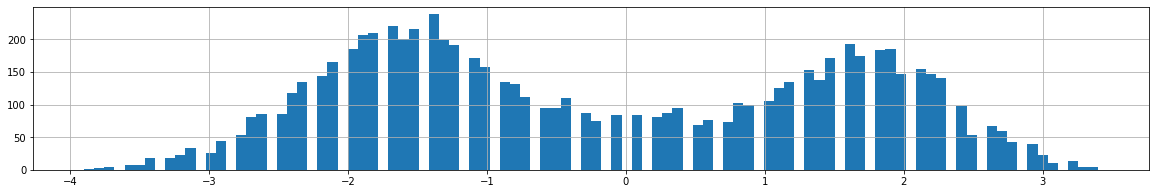

In [4]:
df.score.hist(figsize=(20,3), bins=100);    # shows bimodal distribution (two clusters of sentiments)

<font color='black'>The tokens in VADER's lexicon have continuous valence scores, most of which are clustered around -1.5 and 1.8. We would consider this a bi-modal distribution with counts around left mode being greater suggesting a larger number of negative words. On the other hand, positive words have greater valence on average; and, hence, the mode is at a higher (by magnitude) valence score (i.e., 1.8 vs 1.5). You could also evaluate whether the words with near-zero valence are almost lacking sentiment.

<font color='black'>Next, examine the following emoticons (emotion icons), slang, and words included in VADER's lexicon. For example, `143`=I love you, `8D`=happy face, `sweet<3`=sweetheart, `2g2b4g`=Too good to be forgotten, `ly4e`=Love You Forever

In [5]:
LsNonWords = [s for s in df.index if not s.isalpha()]
df.loc[LsNonWords].T

,143,sweet<3,8d,2g2b4g,(-:0,:-)),ly4e,gr8,:'-),ily2,...,^urs,d;,182,>;(,v.v,</3,4q,187,d:<,d8
score,3.2,3.0,2.9,2.8,2.8,2.8,2.7,2.7,2.7,2.6,...,-2.8,-2.9,-2.9,-2.9,-2.9,-3.0,-3.1,-3.1,-3.2,-3.2


## Simple Application of VADER Analyzer

<font color='black'>Next, apply an analyzer with `sia.polarity_scores()`. By passing some text, you can retrieve scores for text's positivity, negativity, and neutrality as well as compound scores for all three sentiments. 

<font color='black'>However, before implementing the VADER analyzer, you should be familiar with what it can and cannot evaluate. The examples below demonstrate expected and unexpected valence scores for seemingly similar sentences. It's a good idea to first assess your corpora for the needed preprocessing in order to prepare the text for a higher quality evaluation by VADER.

In [6]:
# VADER scores emoticons, capitals, exclamations, adverb boosters
LsDocs = \
  ['Yes', 'No', 'Yes :-(', "good idea", "GOOD idea", "good idea!", "good idea!!!",
   "idea's good!!!!!!!!", "idea's good !!!!!!!!", "good idea!!!!!!!!",      # too many exlamations may fail
   "not a good idea", "it isn't a good idea", "good and risky idea",   # negation and multi-attitude towards the movie
   "idea is good, but risky"]           # conjunction "but" sigmals change in polarity towards dominanty phrase
df = pd.DataFrame([sia.polarity_scores(s) for s in LsDocs], index=LsDocs)
df.T.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).set_precision(2)

,Yes,No,Yes :-(,good idea,GOOD idea,good idea!,good idea!!!,idea's good!!!!!!!!,idea's good !!!!!!!!,good idea!!!!!!!!,not a good idea,it isn't a good idea,good and risky idea,"idea is good, but risky"
neg,0.00,1.00,0.48,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.55,0.45,0.27,0.31
neu,0.00,0.00,0.00,0.26,0.22,0.24,0.21,1.00,0.33,0.20,0.45,0.56,0.30,0.42
pos,1.00,0.00,0.52,0.74,0.78,0.76,0.79,0.00,0.67,0.80,0.00,0.00,0.43,0.27
compound,0.40,-0.30,0.05,0.44,0.56,0.49,0.58,0.00,0.62,0.62,-0.34,-0.34,0.27,-0.06


## Movie Reviews

<font color='black'>Consider 5331 positive and 5331 negative Rotten Tomatoes [movie reviews](https://www.cs.cornell.edu/people/pabo/movie-review-data/) published by [Bo Pang and Lillian Lee](https://arxiv.org/pdf/cs/0205070.pdf) (Cornell University, Computer Science Department) in 2002. Each lower-cased review snippet is approximately one sentence, which is a text length better suited to VADER's algorithm. 

In [7]:
print('files:\t\t', sentence_polarity.fileids())
print('categories:\t', sentence_polarity.categories())

files:		 ['rt-polarity.neg', 'rt-polarity.pos']
categories:	 ['neg', 'pos']


<font color='black'>Here, evaluate all movie reviews with VADER. The binary polarity, `pY`, is computed from the sign of the compound valence score. You can compare it to the expert-assigned polarity, `vY`.

In [8]:
LsPos = [' '.join(sSent) for sSent in sentence_polarity.sents('rt-polarity.pos')]
LsNeg = [' '.join(sSent) for sSent in sentence_polarity.sents('rt-polarity.neg')]
LsReviews = LsPos + LsNeg
LnPolarity = [1] * len(LsPos) + [-1] * len(LsNeg)   # original polarity lacks neutral values

%time dfSP = pd.DataFrame([sia.polarity_scores(s) for s in LsReviews])
dfSP['nChar'] = [len(s) for s in LsReviews]
dfSP['vY'] = LnPolarity
dfSP['pY'] = dfSP.compound.apply(lambda c: -1 if c < 0 else 1 if c >= 0 else 0)   # predicted polarity (based on threshold)
dfSP['review'] = LsReviews
dfSP

CPU times: user 3.37 s, sys: 20 ms, total: 3.39 s
Wall time: 3.39 s


,neg,neu,pos,compound,nChar,vY,pY,review
0,0.000,0.918,0.082,0.3612,177,1,1,"the rock is destined to be the 21st century's new "" conan "" and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal ."
1,0.000,0.758,0.242,0.8069,226,1,1,"the gorgeously elaborate continuation of "" the lord of the rings "" trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth ."
2,0.000,0.594,0.406,0.2617,30,1,1,effective but too-tepid biopic
3,0.000,0.633,0.367,0.8271,89,1,1,"if you sometimes like to go to the movies to have fun , wasabi is a good place to start ."
4,0.086,0.650,0.264,0.6592,111,1,1,"emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one ."
...,...,...,...,...,...,...,...,...
10657,0.279,0.721,0.000,-0.4767,65,-1,-1,a terrible movie that some people will nevertheless find moving .
10658,0.000,0.796,0.204,0.5927,87,-1,1,there are many definitions of 'time waster' but this movie must surely be one of them .
10659,0.171,0.829,0.000,-0.7783,225,-1,-1,"as it stands , crocodile hunter has the hurried , badly cobbled look of the 1959 godzilla , which combined scenes of a japanese monster flick with canned shots of raymond burr commenting on the monster's path of destruction ."
10660,0.000,0.667,0.333,0.3612,52,-1,1,the thing looks like a made-for-home-video quickie .


## Quantitative Performance Metrics

<font color='black'>You can compute performance metrics with a confusion matrix, which shows correctly classified categories on diagonal and failed classifications off diagonal. 

In [9]:
LsLbl = sorted(np.unique(dfSP[['vY','pY']].values.flatten()))         # polarity labels: [-1, 0, 1]
cm = confusion_matrix(y_true=dfSP.vY, y_pred=dfSP.pY, labels=LsLbl)
cm      # this confusion matrix is difficult to interpret due to lack of printed labels

array([[2137, 3194],
       [ 945, 4386]])

<font color='black'>Next, add titles and percentages to this array for convenience. The matrix below shows that roughly 61% of movie reviews were classified correctly, 30% were misclassified as positives, and 9% were misclassified as negatives. 
    
<font color='black'>If you don't have a specific business goal, you could try to preprocess reviews and tune the algorithm to improve the overall correct classifications. However, there are some business cases where one type of misclassification is far costlier than the other. Then you would focus on balance the **overall cost** of misclassifications.

Confusion Matrix: counts and % of total count


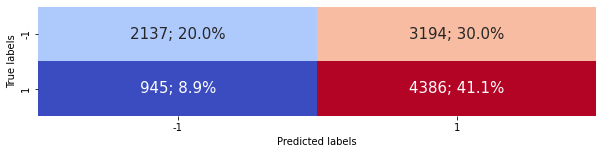

In [10]:
plt.rcParams['figure.figsize'] = [10, 2]
MsTxt = np.core.defchararray.add(np.char.array(cm.astype(str)) + '; ', np.char.array((cm/cm.sum() * 100).round(1)) + '%')

ax = sns.heatmap(cm, annot=MsTxt, cbar=False, cmap='coolwarm', fmt='', annot_kws={"fontsize":15}, xticklabels=LsLbl, yticklabels=LsLbl);
print('Confusion Matrix: counts and % of total count')
ax.set(xlabel='Predicted labels', ylabel='True labels');

<font color='black'>Next, compute precision and recall from the confusion matrix and aggregate these values into an f1 score, which is a single metric (per category) you might be interested in improving.

In [11]:
print(classification_report(y_true=dfSP.vY, y_pred=dfSP.pY, labels=LsLbl))

              precision    recall  f1-score   support

          -1       0.69      0.40      0.51      5331
           1       0.58      0.82      0.68      5331

    accuracy                           0.61     10662
   macro avg       0.64      0.61      0.59     10662
weighted avg       0.64      0.61      0.59     10662



## Improving Lexicon

<font color='black'>Here, sort the misclassified examples by their compound value. 

In [12]:
pd.set_option('display.max_colwidth', 0)
dfSP['isCorrect'] = dfSP.vY * dfSP.pY
dfSP.query('isCorrect==-1').sort_values('compound', ascending=False)

,neg,neu,pos,compound,nChar,vY,pY,review,isCorrect
6847,0.000,0.574,0.426,0.9674,223,-1,1,"it's inoffensive , cheerful , built to inspire the young people , set to an unending soundtrack of beach party pop numbers and aside from its remarkable camerawork and awesome scenery , it's about as exciting as a sunburn .",-1
8492,0.000,0.610,0.390,0.9511,216,-1,1,"the plot's clearly mythic structure may owe more to disney's strong sense of formula than to the original story . but while the highly predictable narrative falls short , treasure planet is truly gorgeous to behold .",-1
7734,0.000,0.607,0.393,0.9501,195,-1,1,"the makers of divine secrets of the ya-ya sisterhood should offer a free ticket ( second prize , of course , two free tickets ) to anyone who can locate a genuinely honest moment in their movie .",-1
7744,0.000,0.546,0.454,0.9431,153,-1,1,"but buying into sham truths and routine "" indie "" filmmaking , freundlich has made just another safe movie . it's not horrible , just horribly mediocre .",-1
9363,0.098,0.237,0.664,0.9403,105,-1,1,it's mindless junk like this that makes you appreciate original romantic comedies like punch-drunk love .,-1
...,...,...,...,...,...,...,...,...,...
3809,0.504,0.403,0.092,-0.9360,130,1,-1,succeeds where its recent predecessor miserably fails because it demands that you suffer the dreadfulness of war from both sides .,-1
932,0.406,0.594,0.000,-0.9398,153,1,-1,"frailty isn't as gory or explicit . but in its child-centered , claustrophobic context , it can be just as frightening and disturbing -- even punishing .",-1
4598,0.501,0.432,0.066,-0.9524,124,1,-1,contrasting the original ringu with the current americanized adaptation is akin to comparing the evil dead with evil dead ii,-1
5179,0.431,0.517,0.052,-0.9674,209,1,-1,"for more than two decades mr . nachtwey has traveled to places in the world devastated by war , famine and poverty and documented the cruelty and suffering he has found with an devastating , eloquent clarity .",-1


<font color='black'>Notice that the strongest misclassifications appear to be related to the length of the text. You could verify this by computing the average length for misclassified and correctly classified examples.

In [13]:
dfSP[['nChar','isCorrect']].groupby('isCorrect').mean().round(1).T

isCorrect,-1,1
nChar,113.7,114.5


<font color='black'>Surprisingly, incorrect sentiment classifications are coming from messages that are about one character shorter, on average. Given a relatively long average sentence, this finding is unlikely to be helpful in improving the model.
    
<font color='black'>Next, try improving your model by hypothesizing about the cause of misclassified movies. 

<font color='black'>One possible cause of a misclassified review could be a polarized movie title that is present within the review text. Consider the movie "*divine secrets of the ya-ya sisterhood*". Its positive reviews are classified correctly, but its negative reviews are classified incorrectly. To improve your model, you could use a named entity tagger to identify movie titles and replace them with a neutral word *'movie'*.

In [14]:
dfSP[dfSP.review.str.lower().str.contains('divine secrets')]

,neg,neu,pos,compound,nChar,vY,pY,review,isCorrect
553,0.197,0.533,0.270,0.4215,115,1,1,"for all its failed connections , divine secrets of the ya-ya sisterhood is nurturing , in a gauzy , dithering way .",1
560,0.000,0.611,0.389,0.9354,176,1,1,"divine secrets of the ya-ya sisterhood may not be exactly divine , but it's definitely -- defiantly -- ya ya , what with all of those terrific songs and spirited performances .",1
1500,0.000,0.719,0.281,0.8402,173,1,1,"another one of those estrogen overdose movies like "" divine secrets of the ya ya sisterhood , "" except that the writing , acting and character development are a lot better .",1
2782,0.000,0.682,0.318,0.8126,145,1,1,me without you has a bracing truth that's refreshing after the phoniness of female-bonding pictures like divine secrets of the ya-ya sisterhood .,1
3510,0.131,0.717,0.152,0.1280,131,1,1,"if divine secrets of the ya-ya sisterhood suffers from a ploddingly melodramatic structure , it comes to life in the performances .",1
4475,0.000,0.864,0.136,0.5023,176,1,1,"to those who have not read the book , the film is a much better mother-daughter tale than last summer's 'divine secrets of the ya-ya sisterhood , ' but that's not saying much .",1
5540,0.000,0.845,0.155,0.2960,97,-1,1,a not-so-divine secrets of the ya-ya sisterhood with a hefty helping of re-fried green tomatoes .,-1
7734,0.000,0.607,0.393,0.9501,195,-1,1,"the makers of divine secrets of the ya-ya sisterhood should offer a free ticket ( second prize , of course , two free tickets ) to anyone who can locate a genuinely honest moment in their movie .",-1


<font color='black'>In the made-up example below, the compound sentiment for the review is strongly positive, which is likely due to presence of the positive word "divine." However, most human evaluators would rate this review as negative. 

In [15]:
sReview = 'divine secrets of the ya-ya sisterhood is not horrible, just horribly mediocre'
print(sia.polarity_scores(sReview))
print(f'score for "divine": ', sia.lexicon['divine'])   # this word is in movie title, not in sentiment

{'neg': 0.0, 'neu': 0.494, 'pos': 0.506, 'compound': 0.8491}
score for "divine":  2.6


<font color='black'>Before spending additional time solving this problem, you should first evaluate whether it is causing many other reviews to be misclassified.

<font color='black'>Another possible cause of misclassification could be that your corpus has words that are absent from VADER's lexicon or incorrectly valued for your purpose. In this case, you could add new words to VADER's lexicon or overwrite their scores. For example, you could expand the lexicon with high frequency tokens and phrases, which have a strong sentiment. 
    
<font color='black'>The UDF `AddWord()` below does just that. You just need to provide the new word and a synonym for that word that already exists in VADER's lexicon. The synonym's valency score will be used for the new word. If the word is already in the lexicon, then this is noted on screen.

In [16]:
# We add new scored words to in-memory dictinary or to vader_lexicon.txt (more persistent)
def AddWord(sNewWord='top-notch', ValenceScore=0):
    '''If the word in not in VADER's lexicon, it is added '''
    if sNewWord in sia.lexicon:
        print(f'{sNewWord} \tis already in the lexicon with a score {sia.lexicon[sNewWord]}')
    else:
        sia.lexicon.update({sNewWord: ValenceScore})                # we can add new words to lexicon's dictionary
        print(f'added "{sNewWord}" with a score of {ValenceScore}')

AddWord('smashing', sia.lexicon['super'])
AddWord('top-notch', sia.lexicon['super'])

added "smashing" with a score of 2.9
added "top-notch" with a score of 2.9


<hr style="border-top: 2px solid #606366; background: transparent;">

# **Optional Practice**

<font color='black'>Now you will practice retrieving valence scores for various words in VADER's lexicon.
    
As you work through these tasks, check your answers by running your code in the *#check solution here* cell, to see if you’ve gotten the correct result. If you get stuck on a task, click the See **solution** drop-down to view the answer.

##  Task 1

Retrieve all words from VADER's lexicon that have the same valence score as "great." Do you agree with these words and their scores?

<b>Hint:</b> Use <code>sia.lexicon</code> as you would any other dictionary. First find the valence score for "great." Then iterate over all <code>.items()</code> to find those keys that have values equal to the score of "great."

In [17]:
# check solution here

<font color=#606366>
    <details><summary><font color=#B31B1B>▶ </font>See <b>solution</b>.</summary>
<pre class="ec">
print(sia.lexicon['great'])  # show valence score of 'great'
print(', '.join(w for w,s in sia.lexicon.items() if s==3.1))
pd.DataFrame.from_dict(sia.lexicon, orient='index', columns=['score']).query('score==3.1').T # alternative solution
</pre>
</details> 
</font>

<hr>

##  Task 2

Retrieve all words containing "nice" with their valence scores from VADER's lexicon. Do you agree with these words and their scores?

<b>Hint:</b> Again, iterate over all <code>.items()</code> of the dictionary and keep only those that have "nice" in the key.

In [18]:
# check solution here

<font color=#606366>
    <details><summary><font color=#B31B1B>▶ </font>See <b>solution</b>.</summary>
<pre class="ec">
print([(w,s) for w,s in sia.lexicon.items() if 'nice' in w])
</pre>
</details> 
</font>

<hr>

##  Task 3

Find all words with valence score in $[-0.1, 0.1]$ interval. Do you agree with these ("neutral") words and their scores?

<b>Hint:</b> You can either iterate over key-value pairs and keep those keys/values that are within 0.1 of zero. Or you can load the dictionary into a dataframe and filter on the score column.

In [19]:
# check solution here

<font color=#606366> 
    <details><summary><font color=#B31B1B>▶ </font>See <b>solution</b>.</summary>
<pre class="ec">
df1 = pd.DataFrame.from_dict(sia.lexicon, orient='index', columns=['score'])
df1.query('score >= -0.1 and score <= 0.1').sort_values('score').T
</pre>
</details> 
</font>
<hr>

##  Task 4

Identify the top 20 shortest misclassified reviews. Which of the words in these reviews are not in VADER's lexicon?

<b>Hint:</b> Filter <code>dfSP</code> on misclassified values and order by character length column.

In [20]:
# check solution here

<font color=#606366>
    <details><summary><font color=#B31B1B>▶ </font>See <b>solution</b>.</summary>
<pre class="ec">
df20 = dfSP.query('isCorrect==-1').sort_values('nChar')[['review','vY']].head(20) # top 20 shortest misclassifications
df20.T
SsRWords = set(' '.join(df20.review.tolist()).split(' ')) # create a list of words from the top 20 reviews
print([(w, sia.lexicon.get(w, '')) for w in SsRWords])    # check each word in lexicon
</pre>
</details> 
</font>

<hr>

##  Task 5


Add missing words to VADER's lexicon with the (subjectively) appropriate valence scores. For example, you could look at a review's sentiment or word synonyms's scores or make up a score.

<b>Hint:</b> This is subjective, but you can web-search synonyms of the words which are not in the lexicon. WordNet library can also be used, but it is unlikely to contain these somewhat rare words.

In [21]:
# check solution here

<font color=#606366>
    <details><summary><font color=#B31B1B>▶ </font>See <b>solution</b>.</summary>
<pre class="ec">
sia.lexicon['weak']
sia.lexicon.update({'crummy': sia.lexicon['inferior']})
dfSP[dfSP.review.str.contains('obvious')][['review']]  # check other reviews containing the word
sia.lexicon.update({'obvious': -0.1})  # give it a smal negative score, obvious~predictabile, slightly negative
sia.lexicon.update({'shallow': sia.lexicon['empty']})
sia.lexicon.update({'execrable': sia.lexicon['awful']})
sia.lexicon.update({'snooze': -0.5})
sia.lexicon.update({'poo': -2})
sia.lexicon.update({'slummer': -2})
sia.lexicon.update({'plain': -0.5})
</pre>
</details> 
</font>

<hr>